# Telecommunication Industry User Analytics
<p>This notebook contains a detailed user analytics on Tellco, a mobile service provider in the Republic of Pefkakia. The aim of this project is to provide a detailed report of the analysis of the dataset by the owners of Tellco. The dataset contains information about the customer and their activities on the network. This analysis should provide a report on opportunities for growth identified and recommendation on whether Tellco is worth buying or selling. </p>
<p>This analysis will be based on the following 4 sub-objectives:
<ol>
    <li>User overview analysis</li>
    <li>User Engagement analysis</li>
    <li>User Experience analysis</li>
    <li>User Satisfaction analysis</li>
</ol>
</p>




## Import the required modules and packages

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
sys.path.append('../scripts')
from load_data import LoadData

In [156]:
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from random import sample
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

## Loading the data into a DataFrame
<p>We begin by first loading the dataset provided in an excel file into a pandas dataframe. The data can be obtained from <a href="https://www.github.com/wakura-mbuya/Tellco-project/tree/master/data">here</a>.</p>
<p>The data was loaded into the DataFrame using <strong><a href="https://www.github.com/wakura-mbuya/Tellco-project/blob/master/scripts/load_data.py">LoadData</a>.</strong> class.</p>

In [2]:
loader = LoadData()
telco_df = loader.read_excel('../data/Week1_challenge_data_source.xlsx')
telco_df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9164566995485190,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


## 1. User Overview analysis
<p>In this section, will conduct Exploratory Data Analysis in order to familiarize ourself with the dataset and explore initial insights to inform further steps in the data analysis. </p>
<p>We will identify and impute missing values and outliers in our dataset. We will use visual and quantitative methods to understand the data. At the end of the exploratory data analysis in this section we would have conducted a full user overview analysis. This section will be based on the folliwing objectives:

   <ul>
    <li> Identifying the top 10 handsets used by the customers </li>
    <li> Identifying the top 3 handset manufacturers</li>
    <li> Identifying the top 5 handsets per top 3 handset manufacturer</li>
    <li> Provide a brief interpretation and recommendation to marketing teams</li>
   </ul>
</p>

### Data cleaning
We will identify missing values and outliers in our dataset and impute them using an appropriate method

In [3]:
# Identify columns with missing values
telco_df.isna().sum()

Bearer Id                                        0
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [4]:
def impute_missing_values(df):
    """
    This function imputes missing values by filling them with the mean
    """
    for i in df.columns:
        df[i].fillna(df[i].mode()[0], inplace=True)
    return df

#### Drop Missing values in some of the columns 
Drop with missing values in the columns IMSI, MSIDN/Number, IMEI, Handset Manufacturer, Handset Type, Last Location Name. This is because imputing these values with mean or medium do not not make sense as these values are to be unique

In [5]:
#drop rows with missing imei, msisdn, imsi, handset manufacturer and handset type
telco_df_dropped = telco_df.dropna(subset=['IMSI', 'MSISDN/Number', 'IMEI', 'Handset Manufacturer', 'Handset Type', 'Last Location Name'])
telco_df_dropped.shape #show the new shape of the dataframe

(148346, 55)

#### Impute the missing values in the other columns with the mean of the respective column

In [6]:
telco_clean = impute_missing_values(telco_df_dropped)
telco_clean.head()

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9164566995485190,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [7]:
new_df = telco_clean[['IMSI', 'Handset Manufacturer', 'Handset Type']].copy()
#new_df.to_csv('user_overview.csv')

In [13]:
#Run unit test on load_data.py
%run ../tests/test_load_data.py

.
----------------------------------------------------------------------
Ran 1 test in 239.269s

OK


In [8]:
#Chech if there are any missing values
telco_clean.isna().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

#### Check the Data types of all columns to ensure that they are correct

In [10]:
telco_clean.dtypes

Bearer Id                                           uint64
Start                                       datetime64[ns]
Start ms                                           float64
End                                         datetime64[ns]
End ms                                             float64
Dur. (ms)                                          float64
IMSI                                               float64
MSISDN/Number                                      float64
IMEI                                               float64
Last Location Name                                  object
Avg RTT DL (ms)                                    float64
Avg RTT UL (ms)                                    float64
Avg Bearer TP DL (kbps)                            float64
Avg Bearer TP UL (kbps)                            float64
TCP DL Retrans. Vol (Bytes)                        float64
TCP UL Retrans. Vol (Bytes)                        float64
DL TP < 50 Kbps (%)                                float

All the columns are of the correct datatype

In [11]:
def convertColumnTypes(df, columnNames, dataType):
    """
    This function converts the datatypes of columns specified to the data type specified
    """
    for i in columnNames:
        df[i]=df[i].map(dataType)
        

#### User Aggregation
We are going to aggregate users based on the information in the columns:
   <ul>
    <li>Number of xDR sessions</li>
    <li>Session duration</li>
    <li>The total download (DL) and upload (UL) data</li>
    <li>The total data volume (in Bytes) during this session in each application </li>
   </ul>
    

In [12]:
df = telco_clean.groupby('IMSI').aggregate({'Bearer Id': 'count', 
                                    'Dur. (ms)': 'sum', 
                                    'Total DL (Bytes)': 'sum', 
                                    'Total UL (Bytes)': 'sum', 
                                    'Social Media DL (Bytes)': 'sum', 
                                    'Social Media UL (Bytes)':  'sum', 
                                    'Google DL (Bytes)': 'sum',
                                    'Google UL (Bytes)': 'sum', 
                                    'Email DL (Bytes)': 'sum',
                                    'Email UL (Bytes)': 'sum',
                                    'Youtube DL (Bytes)': 'sum', 
                                    'Youtube UL (Bytes)': 'sum',
                                    'Netflix DL (Bytes)': 'sum',
                                    'Netflix UL (Bytes)': 'sum',
                                    'Gaming DL (Bytes)': 'sum',
                                    'Gaming UL (Bytes)': 'sum',
                                    'Other DL (Bytes)': 'sum',
                                    'Other UL (Bytes)': 'sum'
                                 }).reset_index()

In [13]:
df.head()

,IMSI,Bearer Id,Dur. (ms),Total DL (Bytes),Total UL (Bytes),Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes)
0,2.040471e+14,1,869844.0,78697597.0,60456049.0,1500145.0,45943.0,5985089.0,3233558.0,2518425.0,812549.0,18980320.0,21960390.0,21621336.0,7224894.0,28092282.0,14977978.0,3.891597e+08,12200737.0
1,2.040808e+14,1,877385.0,194828056.0,37295915.0,668596.0,46628.0,8572779.0,1865881.0,842279.0,678492.0,9839889.0,2120016.0,10340908.0,16251392.0,164563605.0,13485133.0,4.676781e+08,2848373.0
2,2.082001e+14,1,86019.0,31376981.0,53794658.0,3073697.0,49084.0,603691.0,1020971.0,3076735.0,580766.0,5556563.0,14325876.0,15305361.0,16525201.0,3760934.0,5363582.0,5.000445e+08,15929178.0
3,2.082001e+14,1,86254.0,392918313.0,33583272.0,2542767.0,34337.0,10699827.0,3111651.0,3248863.0,606871.0,22414714.0,3242918.0,10065639.0,17720213.0,343946503.0,159394.0,3.009029e+08,8707888.0
4,2.082001e+14,2,573923.0,961767023.0,71325004.0,3326811.0,99905.0,9118088.0,2547799.0,4225757.0,1338705.0,4046597.0,9793604.0,30748449.0,26594966.0,910301321.0,7383445.0,1.055869e+09,23566580.0


In [63]:
def combineColumns(df, columns):
    
    for key in columns:
        col1=columns[key][0]
        col2=columns[key][1]
        df[key]=df[col1]+df[col2]
        df=df.drop(columns=[col1,col2])
    return df

import copy

In [15]:
df.columns.tolist()

['IMSI',
 'Bearer Id',
 'Dur. (ms)',
 'Total DL (Bytes)',
 'Total UL (Bytes)',
 'Social Media DL (Bytes)',
 'Social Media UL (Bytes)',
 'Google DL (Bytes)',
 'Google UL (Bytes)',
 'Email DL (Bytes)',
 'Email UL (Bytes)',
 'Youtube DL (Bytes)',
 'Youtube UL (Bytes)',
 'Netflix DL (Bytes)',
 'Netflix UL (Bytes)',
 'Gaming DL (Bytes)',
 'Gaming UL (Bytes)',
 'Other DL (Bytes)',
 'Other UL (Bytes)']

In [16]:
my_dict= {'Social Media': ['Social Media DL (Bytes)', 'Social Media UL (Bytes)'],
          'Google': ['Google DL (Bytes)', 'Google UL (Bytes)'],
          'Email': ['Email DL (Bytes)', 'Email UL (Bytes)'],
          'Youtube': ['Youtube DL (Bytes)', 'Youtube UL (Bytes)'],
          'Netflix': ['Netflix DL (Bytes)', 'Netflix UL (Bytes)'],
          'Gaming': ['Gaming DL (Bytes)', 'Gaming UL (Bytes)'],
          'Other': ['Other DL (Bytes)', 'Other UL (Bytes)']
         }
user_info = combineColumns(df, my_dict)
user_info.head()
user_info.to_csv("user_app_usage.csv")        

#### User_info Variables description
We describe all the relevant variables and data types of the newly formed user_info dataframe which is an aggregation of user based on the volumes of data they use during an xDR session

In [17]:
user_info.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106351 entries, 0 to 106350
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   IMSI              106351 non-null  float64
 1   Bearer Id         106351 non-null  int64  
 2   Dur. (ms)         106351 non-null  float64
 3   Total DL (Bytes)  106351 non-null  float64
 4   Total UL (Bytes)  106351 non-null  float64
 5   Social Media      106351 non-null  float64
 6   Google            106351 non-null  float64
 7   Email             106351 non-null  float64
 8   Youtube           106351 non-null  float64
 9   Netflix           106351 non-null  float64
 10  Gaming            106351 non-null  float64
 11  Other             106351 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 9.7 MB


In [18]:
#Look at the shape of the dataframe
user_info.shape

(106351, 12)

#### Non-Graphical Univariate analysis
We then conduct a non-graphical univariate analysis on the dataframe by computing the dispersion parameters for each quantitative variables

In [19]:
user_info[['Dur. (ms)','Total DL (Bytes)','Total UL (Bytes)','Social Media','Google','Email','Youtube','Netflix','Gaming','Other']].describe()

,Dur. (ms),Total DL (Bytes),Total UL (Bytes),Social Media,Google,Email,Youtube,Netflix,Gaming,Other
count,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05,1.063510e+05
mean,1.466420e+05,6.342476e+08,5.735734e+07,2.549910e+06,1.089098e+07,3.151163e+06,3.158412e+07,3.156503e+07,6.003381e+08,5.989977e+08
std,1.861173e+05,4.650188e+08,3.568615e+07,1.908677e+06,7.551163e+06,2.224336e+06,2.131071e+07,2.130507e+07,4.495975e+08,4.492046e+08
min,7.142000e+03,8.827082e+06,2.866892e+06,1.563000e+03,4.033000e+04,1.817600e+04,7.890300e+04,1.845690e+05,3.063580e+05,1.490450e+05
25%,7.273550e+04,3.150687e+08,3.640236e+07,1.211830e+06,5.945850e+06,1.675358e+06,1.863829e+07,1.857020e+07,2.883087e+08,2.858938e+08
50%,1.032480e+05,5.707809e+08,4.682052e+07,2.305817e+06,9.592535e+06,2.801284e+06,2.681849e+07,2.673116e+07,5.428493e+08,5.401950e+08
75%,1.727990e+05,8.078833e+08,6.587011e+07,3.309194e+06,1.322390e+07,3.849244e+06,3.796169e+07,3.800361e+07,7.777531e+08,7.756827e+08
max,1.855375e+07,8.156743e+09,7.295774e+08,4.337478e+07,1.521919e+08,4.241878e+07,4.529588e+08,3.995191e+08,7.749432e+09,8.167878e+09


#### Graphical Univariate Analysis
We conduct a graphical univariate analysis by identifying the most suitable plotting option for each variable and interpret the findings. We will use a distplot to visualize the distribution of each of the numerical variable in our dataset

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Social Media (Bytes)')

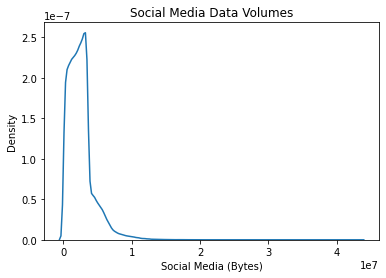

In [22]:
sns.distplot(x = user_info['Social Media'], hist=False)
plt.title('Social Media Data Volumes')
# Set x-axis label
plt.xlabel('Social Media (Bytes)')

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Google (Bytes)')

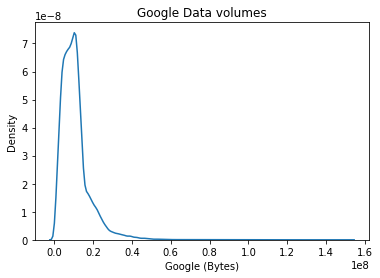

In [23]:
sns.distplot(x = user_info['Google'], hist=False)
plt.title('Google Data volumes')
# Set x-axis label
plt.xlabel('Google (Bytes)')

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Email (Bytes)')

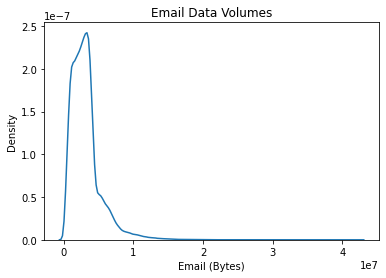

In [24]:
sns.distplot(x = user_info['Email'], hist=False)
plt.title('Email Data Volumes')
# Set x-axis label
plt.xlabel('Email (Bytes)')

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Youtube (Bytes)')

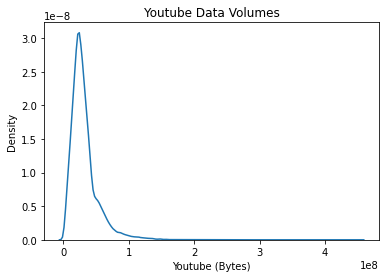

In [25]:
sns.distplot(x = user_info['Youtube'], hist=False)
plt.title('Youtube Data Volumes')
# Set x-axis label
plt.xlabel('Youtube (Bytes)')

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Gaming (Bytes)')

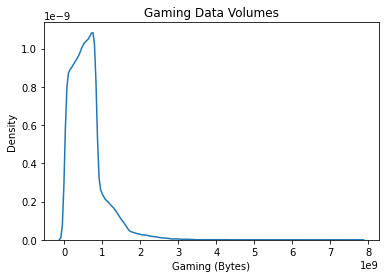

In [26]:
sns.distplot(x = user_info['Gaming'], hist=False)
plt.title('Gaming Data Volumes')
# Set x-axis label
plt.xlabel('Gaming (Bytes)')

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Netflixj (Bytes)')

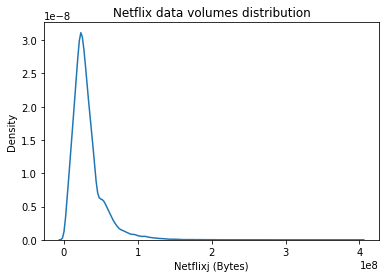

In [27]:
sns.distplot(x = user_info['Netflix'], hist=False)
plt.title('Netflix data volumes distribution')
# Set x-axis label
plt.xlabel('Netflixj (Bytes)')

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Other Applications')

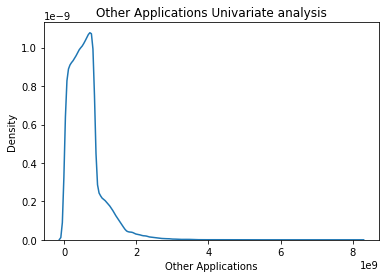

In [28]:
sns.distplot(x = user_info['Other'], hist=False)
plt.title('Other Applications Univariate analysis')
# Set x-axis label
plt.xlabel('Other Applications')



ValueError: num must be 1 <= num <= 9, not 10

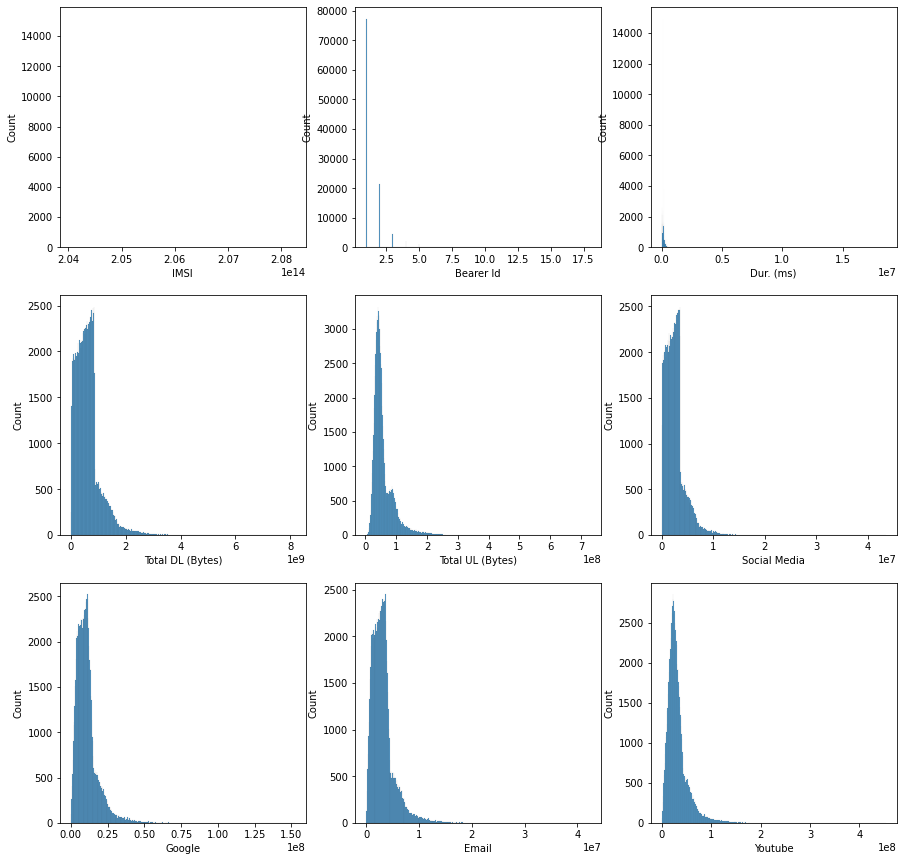

In [29]:
cols = 3
rows = 3
num_cols =user_info.select_dtypes(exclude='object').columns
fig = plt.figure( figsize=(cols*5, rows*5))
for i, col in enumerate(num_cols):
    
    ax=fig.add_subplot(rows,cols,i+1)
    
    sns.histplot(x = user_info[col], ax = ax)
    
fig.tight_layout()  
plt.show()

#### Bivariete Analysis
We explore the relationship between each application and the total downlink (DL) + uplink (UL) data using a scatter plot

In [30]:
user_info['Total Data(Bytes)']=user_info['Total DL (Bytes)']+user_info['Total UL (Bytes)']
user_info.head()

,IMSI,Bearer Id,Dur. (ms),Total DL (Bytes),Total UL (Bytes),Social Media,Google,Email,Youtube,Netflix,Gaming,Other,Total Data(Bytes)
0,2.040471e+14,1,869844.0,78697597.0,60456049.0,1546088.0,9218647.0,3330974.0,40940710.0,28846230.0,43070260.0,4.013605e+08,1.391536e+08
1,2.040808e+14,1,877385.0,194828056.0,37295915.0,715224.0,10438660.0,1520771.0,11959905.0,26592300.0,178048738.0,4.705265e+08,2.321240e+08
2,2.082001e+14,1,86019.0,31376981.0,53794658.0,3122781.0,1624662.0,3657501.0,19882439.0,31830562.0,9124516.0,5.159737e+08,8.517164e+07
3,2.082001e+14,1,86254.0,392918313.0,33583272.0,2577104.0,13811478.0,3855734.0,25657632.0,27785852.0,344105897.0,3.096107e+08,4.265016e+08
4,2.082001e+14,2,573923.0,961767023.0,71325004.0,3426716.0,11665887.0,5564462.0,13840201.0,57343415.0,917684766.0,1.079435e+09,1.033092e+09


Text(0, 0.5, 'Total Data(Bytes)')

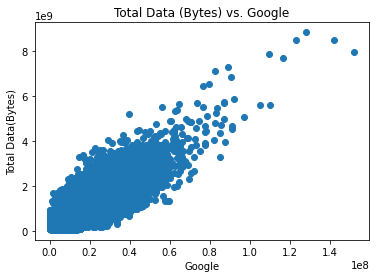

In [31]:
#Total Data(Bytes) against Google
plt.scatter(user_info['Google'], user_info['Total Data(Bytes)'])
plt.title('Total Data (Bytes) vs. Google')
plt.xlabel('Google')
plt.ylabel('Total Data(Bytes)')

Text(0, 0.5, 'Total Data(Bytes)')

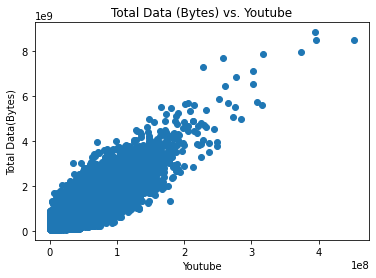

In [32]:
#Total Data(Bytes) against Google
plt.scatter(user_info['Youtube'], user_info['Total Data(Bytes)'])
plt.title('Total Data (Bytes) vs. Youtube')
plt.xlabel('Youtube')
plt.ylabel('Total Data(Bytes)')

Text(0, 0.5, 'Total Data(Bytes)')

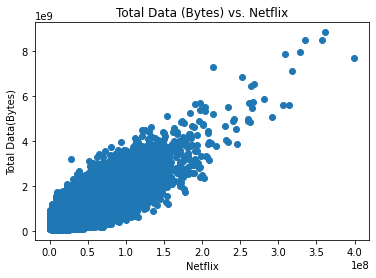

In [33]:
#Total Data(Bytes) against Netflix
plt.scatter(user_info['Netflix'], user_info['Total Data(Bytes)'])
plt.title('Total Data (Bytes) vs. Netflix')
plt.xlabel('Netflix')
plt.ylabel('Total Data(Bytes)')

Text(0, 0.5, 'Total Data(Bytes)')

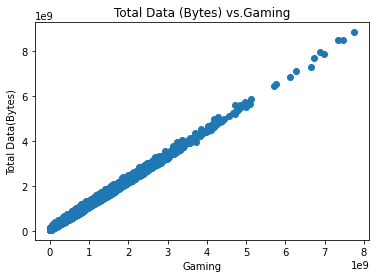

In [34]:
#Total Data(Bytes) against Gaming
plt.scatter(user_info['Gaming'], user_info['Total Data(Bytes)'])
plt.title('Total Data (Bytes) vs.Gaming')
plt.xlabel('Gaming')
plt.ylabel('Total Data(Bytes)')

Text(0, 0.5, 'Total Data(Bytes)')

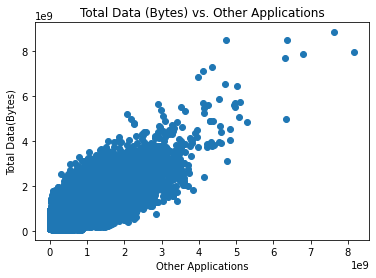

In [35]:
#Total Data(Bytes) against Google
plt.scatter(user_info['Other'], user_info['Total Data(Bytes)'])
plt.title('Total Data (Bytes) vs. Other Applications')
plt.xlabel('Other Applications')
plt.ylabel('Total Data(Bytes)')

#### Variables Transformation
We segment the users into top five decile classes based on the total duration for all session and compute the total data downlink (DL) + uplink (UP) per decile class

In [36]:
#Segment users into 5 decile classes based on total duration for all sessions
user_info['segment'] = pd.qcut(user_info['Dur. (ms)'], q=5, labels=['class 1', 'class 2', 'class 3', 'class 4', 'class 5'])
user_info.head()

,IMSI,Bearer Id,Dur. (ms),Total DL (Bytes),Total UL (Bytes),Social Media,Google,Email,Youtube,Netflix,Gaming,Other,Total Data(Bytes),segment
0,2.040471e+14,1,869844.0,78697597.0,60456049.0,1546088.0,9218647.0,3330974.0,40940710.0,28846230.0,43070260.0,4.013605e+08,1.391536e+08,class 5
1,2.040808e+14,1,877385.0,194828056.0,37295915.0,715224.0,10438660.0,1520771.0,11959905.0,26592300.0,178048738.0,4.705265e+08,2.321240e+08,class 5
2,2.082001e+14,1,86019.0,31376981.0,53794658.0,3122781.0,1624662.0,3657501.0,19882439.0,31830562.0,9124516.0,5.159737e+08,8.517164e+07,class 2
3,2.082001e+14,1,86254.0,392918313.0,33583272.0,2577104.0,13811478.0,3855734.0,25657632.0,27785852.0,344105897.0,3.096107e+08,4.265016e+08,class 2
4,2.082001e+14,2,573923.0,961767023.0,71325004.0,3426716.0,11665887.0,5564462.0,13840201.0,57343415.0,917684766.0,1.079435e+09,1.033092e+09,class 5


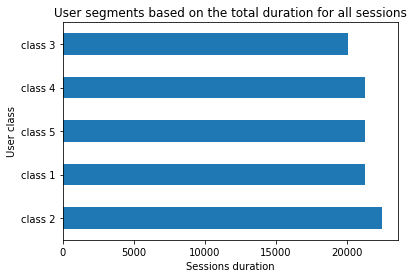

In [37]:
# Visualize the segments in a bar chart
user_info['segment'].value_counts().plot(kind='barh')
plt.title('User segments based on the total duration for all sessions')
plt.xlabel('Sessions duration')
plt.ylabel('User class')
plt.show()

In [38]:
# compute the total data volume (in Bytes) per decile class
user_segment = user_info.groupby(pd.qcut(user_info['Dur. (ms)'], q=5, labels=['class 1', 'class 2', 'class 3', 'class 4', 'class 5']))['Total Data(Bytes)'].sum()
user_segment

Dur. (ms)
class 1    1.152440e+13
class 2    1.233818e+13
class 3    1.167412e+13
class 4    1.391849e+13
class 5    2.409768e+13
Name: Total Data(Bytes), dtype: float64

#### Correlation Analysis
We compute the correlation matrix for the following variables:
<ul>
    <li>Social Media data</li>
    <li>Google data </li>
    <li>Email data</li>
    <li>Youtube data</li>
    <li>Netflix data</li>
    <li>Gaming data</li>
    <li>Other data</li>
 </ul>

In [39]:
#computing the correlation of the above variables
corr = user_info.corr()
corr=corr.drop(columns = ['IMSI', 'Bearer Id', 'Dur. (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)', 'Total Data(Bytes)'], axis=0)
corr=corr.drop(['IMSI', 'Bearer Id', 'Dur. (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)', 'Total Data(Bytes)'])
corr

,Social Media,Google,Email,Youtube,Netflix,Gaming,Other
Social Media,1.000000,0.643289,0.634276,0.659589,0.660080,0.590574,0.591662
Google,0.643289,1.000000,0.688695,0.718857,0.716468,0.642482,0.642987
Email,0.634276,0.688695,1.000000,0.704919,0.705730,0.627854,0.631347
Youtube,0.659589,0.718857,0.704919,1.000000,0.738643,0.657713,0.660620
Netflix,0.660080,0.716468,0.705730,0.738643,1.000000,0.657634,0.656074
Gaming,0.590574,0.642482,0.627854,0.657713,0.657634,1.000000,0.586691
Other,0.591662,0.642987,0.631347,0.660620,0.656074,0.586691,1.000000


In [40]:
len(corr.columns)

7

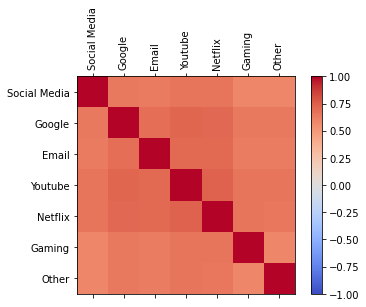

In [41]:
#Visualizing the correlation using a correlation matrix plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)
plt.show()

#### Dimensionality Reduction
We perform a principal component analysis (PCA) on the dataset to reduce the dimensions of our data

In [42]:
from sklearn.decomposition import PCA

In [43]:
# PCA

# Prepare X and Y
Y = user_info.loc[:, '0']
X = user_info.drop(['0'], axis=1)
pca = PCA()
user_info_pca= pca.fit_transform(X=X)

# Store as dataframe and print
df_pca = pd.DataFrame(df_pca)
print(df_pca.shape)  #> (3147, 784)
df_pca.round(2).head()

KeyError: '0'

### 2. User Engagement Analysis

In [45]:
telco_clean.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9164566995485190,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [46]:
df = telco_clean.groupby('MSISDN/Number').aggregate({'Dur. (ms)': 'sum', 
                                                     'Total UL (Bytes)': 'sum',
                                                     'Total DL (Bytes)': 'sum',
                                 }).reset_index()
df.head()

,MSISDN/Number,Dur. (ms),Total UL (Bytes),Total DL (Bytes)
0,3.360100e+10,116720.0,36053108.0,8.426375e+08
1,3.360100e+10,181230.0,36104459.0,1.207552e+08
2,3.360100e+10,134969.0,39306820.0,5.566597e+08
3,3.360101e+10,49878.0,20327526.0,4.019932e+08
4,3.360101e+10,37104.0,94280527.0,1.363130e+09


In [47]:
df['Total Traffic (Bytes)']=df['Total UL (Bytes)'] + df['Total DL (Bytes)']
df.head()

,MSISDN/Number,Dur. (ms),Total UL (Bytes),Total DL (Bytes),Total Traffic (Bytes)
0,3.360100e+10,116720.0,36053108.0,8.426375e+08,8.786906e+08
1,3.360100e+10,181230.0,36104459.0,1.207552e+08,1.568596e+08
2,3.360100e+10,134969.0,39306820.0,5.566597e+08,5.959665e+08
3,3.360101e+10,49878.0,20327526.0,4.019932e+08,4.223207e+08
4,3.360101e+10,37104.0,94280527.0,1.363130e+09,1.457411e+09


In [49]:
# Top 10 customers per  total duration
dur_df = df.sort_values(by='Dur. (ms)', ascending=False)
dur_df.head(10)
           

,MSISDN/Number,Dur. (ms),Total UL (Bytes),Total DL (Bytes),Total Traffic (Bytes)
13107,3.362578e+10,18553754.0,729577380.0,7.770043e+09,8.499621e+09
6394,3.361489e+10,9966898.0,689483001.0,8.156743e+09,8.846226e+09
92486,3.376054e+10,9279434.0,703478581.0,7.811295e+09,8.514774e+09
13451,3.362632e+10,8791927.0,669650721.0,7.301517e+09,7.971167e+09
64825,3.366716e+10,8744914.0,566326364.0,5.052068e+09,5.618394e+09
56896,3.366469e+10,6288730.0,402180804.0,5.279827e+09,5.682007e+09
656,3.360313e+10,6287761.0,435587631.0,4.540607e+09,4.976195e+09
50046,3.366284e+10,5659733.0,365404250.0,3.490821e+09,3.856225e+09
65725,3.366746e+10,5649882.0,266222647.0,2.334299e+09,2.600522e+09
92141,3.376041e+10,5321667.0,521518890.0,6.610852e+09,7.132371e+09


In [50]:
# Top 10 customers per  total traffic 
traffic_df = df.sort_values(by='Dur. (ms)', ascending=False)
traffic_df.head(10)

,MSISDN/Number,Dur. (ms),Total UL (Bytes),Total DL (Bytes),Total Traffic (Bytes)
13107,3.362578e+10,18553754.0,729577380.0,7.770043e+09,8.499621e+09
6394,3.361489e+10,9966898.0,689483001.0,8.156743e+09,8.846226e+09
92486,3.376054e+10,9279434.0,703478581.0,7.811295e+09,8.514774e+09
13451,3.362632e+10,8791927.0,669650721.0,7.301517e+09,7.971167e+09
64825,3.366716e+10,8744914.0,566326364.0,5.052068e+09,5.618394e+09
56896,3.366469e+10,6288730.0,402180804.0,5.279827e+09,5.682007e+09
656,3.360313e+10,6287761.0,435587631.0,4.540607e+09,4.976195e+09
50046,3.366284e+10,5659733.0,365404250.0,3.490821e+09,3.856225e+09
65725,3.366746e+10,5649882.0,266222647.0,2.334299e+09,2.600522e+09
92141,3.376041e+10,5321667.0,521518890.0,6.610852e+09,7.132371e+09


In [51]:
# Normalize Dur. (ms) column
normalized_df=(df-df.mean())/df.std()
normalized_df.head()


,MSISDN/Number,Dur. (ms),Total UL (Bytes),Total DL (Bytes),Total Traffic (Bytes)
0,-0.003994,-0.160763,-0.596979,0.448148,0.380618
1,-0.003994,0.185848,-0.595540,-1.104236,-1.087865
2,-0.003994,-0.062711,-0.505802,-0.166837,-0.194552
3,-0.003994,-0.519903,-1.037646,-0.499443,-0.547815
4,-0.003994,-0.588537,1.034688,1.567451,1.557959


In [52]:
# apply normalization using sklearn
def data_normalizer(df, columns):
    """
    Normalize the columns in the dataframe and return a normalized dataframe
    """
    for col in columns:
        df[col] = MinMaxScaler().fit_transform(np.array(df[col]).reshape(-1,1))
    return df
    

In [53]:
normalized_df=data_normalizer(df, ['Dur. (ms)', 'Total Traffic (Bytes)'])
normalized_df.head()

,MSISDN/Number,Dur. (ms),Total UL (Bytes),Total DL (Bytes),Total Traffic (Bytes)
0,3.360100e+10,0.005908,36053108.0,8.426375e+08,0.095931
1,3.360100e+10,0.009387,36104459.0,1.207552e+08,0.014026
2,3.360100e+10,0.006892,39306820.0,5.566597e+08,0.063851
3,3.360101e+10,0.002304,20327526.0,4.019932e+08,0.044148
4,3.360101e+10,0.001615,94280527.0,1.363130e+09,0.161598


In [54]:
normalized_df.drop(columns=['Total UL (Bytes)', 'Total DL (Bytes)'], inplace=True)


In [55]:
normalized_df.head()

,MSISDN/Number,Dur. (ms),Total Traffic (Bytes)
0,3.360100e+10,0.005908,0.095931
1,3.360100e+10,0.009387,0.014026
2,3.360100e+10,0.006892,0.063851
3,3.360101e+10,0.002304,0.044148
4,3.360101e+10,0.001615,0.161598


In [56]:
#Run k-3 cluster of the 2 metrics
df_new = df[['Dur. (ms)', 'Total Traffic (Bytes)']].copy()
kmeans = KMeans(n_clusters=3).fit(df_new)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.0054871  0.03455792]
 [0.00716556 0.09112676]
 [0.02031553 0.20757997]]


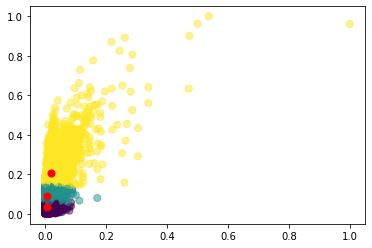

In [57]:
plt.scatter(df_new['Dur. (ms)'], df_new['Total Traffic (Bytes)'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [58]:
df_new.describe()

,Dur. (ms),Total Traffic (Bytes)
count,106352.000000,106352.000000
mean,0.007522,0.074702
std,0.010035,0.055776
min,0.000000,0.000000
25%,0.003536,0.036945
50%,0.005182,0.066396
75%,0.008932,0.093577
max,1.000000,1.000000


#### Analyzing Total User Traffic Per Application

In [60]:
#Aggregate the dataset based on user's MSISDN/Number and the total data traffic for each application
app_traffic=telco_clean.groupby('MSISDN/Number').aggregate({'Social Media DL (Bytes)':'sum',
                                                            'Social Media UL (Bytes)':'sum',
                                                            'Google DL (Bytes)':'sum',
                                                            'Google UL (Bytes)':'sum',
                                                            'Email DL (Bytes)':'sum',
                                                            'Email UL (Bytes)':'sum',
                                                            'Youtube DL (Bytes)':'sum',
                                                            'Youtube UL (Bytes)':'sum',
                                                            'Netflix DL (Bytes)':'sum',
                                                            'Netflix UL (Bytes)':'sum',
                                                            'Gaming DL (Bytes)':'sum',
                                                            'Gaming UL (Bytes)':'sum',
                                                            'Other DL (Bytes)':'sum',
                                                            'Other UL (Bytes)':'sum'
                                                            }).reset_index()

In [64]:
#Combine the uplink and downlink data volumes for each application
columns = {'Social media':['Social Media DL (Bytes)','Social Media UL (Bytes)'],
           'Google':['Google DL (Bytes)', 'Google UL (Bytes)'],
           'Email':['Email DL (Bytes)', 'Email UL (Bytes)'],
           'Youtube':['Youtube DL (Bytes)', 'Youtube UL (Bytes)'],
           'Netflix':['Netflix DL (Bytes)', 'Netflix UL (Bytes)'],
           'Gaming':['Gaming DL (Bytes)', 'Gaming UL (Bytes)'],
           'Other Apps':['Other DL (Bytes)', 'Other UL (Bytes)']
          }
app_traffic= combineColumns(app_traffic, columns)
app_traffic.head()

,MSISDN/Number,Social media,Google,Email,Youtube,Netflix,Gaming,Other Apps
0,3.360100e+10,2232135.0,4389005.0,1331362.0,21624548.0,27180981.0,8.124587e+08,386570872.0
1,3.360100e+10,2660565.0,5334863.0,3307781.0,12432223.0,11221763.0,1.197501e+08,281710071.0
2,3.360100e+10,3195623.0,3443126.0,3205380.0,21333570.0,19353900.0,5.388277e+08,501693672.0
3,3.360101e+10,280294.0,9678493.0,2284670.0,6977321.0,1942092.0,3.911261e+08,35279702.0
4,3.360101e+10,2912542.0,18499616.0,3305469.0,41533002.0,49201724.0,1.314798e+09,804804484.0


##### Top 10 most engaged users per application


In [67]:
#Social Media
app_traffic[['MSISDN/Number','Social media']].sort_values(by = 'Social media', ascending=False).head(10)

,MSISDN/Number,Social media
13451,3.362632e+10,43374779.0
92486,3.376054e+10,39783189.0
36867,3.365973e+10,35412358.0
6394,3.361489e+10,28294544.0
13107,3.362578e+10,27135500.0
64825,3.366716e+10,24247850.0
105638,3.378632e+10,23974919.0
70635,3.366907e+10,23800834.0
656,3.360313e+10,23077825.0
60067,3.366553e+10,22586033.0


In [69]:
#Google
app_traffic[['MSISDN/Number','Google']].sort_values(by = 'Google', ascending=False).head(10)

,MSISDN/Number,Google
13451,3.362632e+10,152191852.0
13107,3.362578e+10,142307915.0
6394,3.361489e+10,127973787.0
92486,3.376054e+10,123223099.0
36867,3.365973e+10,116516345.0
105638,3.378632e+10,110254484.0
75999,3.367588e+10,109860502.0
64825,3.366716e+10,105032696.0
94208,3.376127e+10,97089988.0
85904,3.369876e+10,91935151.0


In [70]:
#Email
app_traffic[['MSISDN/Number','Email']].sort_values(by = 'Email', ascending=False).head(10)

,MSISDN/Number,Email
13451,3.362632e+10,42418782.0
6394,3.361489e+10,40788634.0
13107,3.362578e+10,40633966.0
105638,3.378632e+10,36310123.0
36867,3.365973e+10,35999792.0
92486,3.376054e+10,33693767.0
75999,3.367588e+10,31514421.0
59816,3.366546e+10,30417885.0
64825,3.366716e+10,30335796.0
86045,3.369879e+10,29059042.0


In [72]:
#Youtuve
app_traffic[['MSISDN/Number','Youtube']].sort_values(by = 'Youtube', ascending=False).head(10)

,MSISDN/Number,Youtube
13107,3.362578e+10,452958769.0
92486,3.376054e+10,396289198.0
6394,3.361489e+10,394370218.0
13451,3.362632e+10,374483047.0
75999,3.367588e+10,317410572.0
64825,3.366716e+10,315231310.0
13918,3.362708e+10,308790774.0
92141,3.376041e+10,303169107.0
86045,3.369879e+10,302661958.0
656,3.360313e+10,284090139.0


In [73]:
#Netflix
app_traffic[['MSISDN/Number','Netflix']].sort_values(by = 'Netflix', ascending=False).head(10)

,MSISDN/Number,Netflix
36867,3.365973e+10,399519079.0
6394,3.361489e+10,361401046.0
13107,3.362578e+10,356980607.0
92486,3.376054e+10,334643269.0
13451,3.362632e+10,328725740.0
92141,3.376041e+10,318347546.0
64825,3.366716e+10,313939488.0
75999,3.367588e+10,309093159.0
105638,3.378632e+10,305939790.0
94208,3.376127e+10,292091341.0


In [74]:
#Gaming
app_traffic[['MSISDN/Number','Gaming']].sort_values(by = 'Gaming', ascending=False).head(10)

,MSISDN/Number,Gaming
6394,3.361489e+10,7.749432e+09
92486,3.376054e+10,7.461045e+09
13107,3.362578e+10,7.326673e+09
75999,3.367588e+10,6.970568e+09
13451,3.362632e+10,6.887572e+09
36867,3.365973e+10,6.725559e+09
62746,3.366646e+10,6.646303e+09
92141,3.376041e+10,6.268620e+09
56977,3.366471e+10,6.103856e+09
86045,3.369879e+10,5.753743e+09


In [75]:
#Other Apps
app_traffic[['MSISDN/Number','Other Apps']].sort_values(by = 'Other Apps', ascending=False).head(10)

,MSISDN/Number,Other Apps
13451,3.362632e+10,8.167878e+09
6394,3.361489e+10,7.639264e+09
75999,3.367588e+10,6.798515e+09
13107,3.362578e+10,6.354583e+09
656,3.360313e+10,6.326671e+09
36867,3.365973e+10,6.317415e+09
13861,3.362695e+10,5.305448e+09
13918,3.362708e+10,5.117791e+09
94208,3.376127e+10,5.077779e+09
30555,3.365836e+10,5.013651e+09


##### Top 3 most used applications

In [78]:
app_traffic[['Social media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other Apps']].sum().sort_values(ascending=False).head(3)

Gaming        6.384655e+13
Other Apps    6.370400e+13
Youtube       3.359002e+12
dtype: float64

##### Ploting the top 3 application total traffic

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

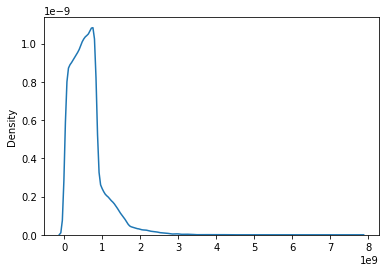

In [80]:
#Gaming
sns.distplot(x= app_traffic['Gaming'], hist=False)

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

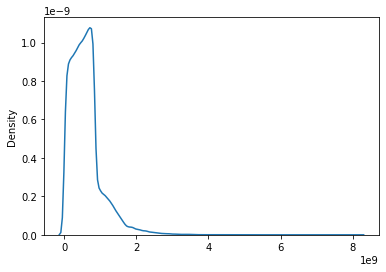

In [81]:
#Other apps
sns.distplot(x= app_traffic['Other Apps'], hist=False)

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

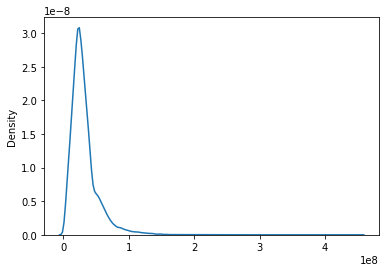

In [82]:
#Youtube
sns.distplot(x= app_traffic['Youtube'], hist=False)

#### K-means clustering using Elbow method

In [93]:
X =app_traffic

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [94]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 23006396690.765163
2 : 6455507894.366018
3 : 529441348.9519714
4 : 498246068.2849819
5 : 391734372.28454727
6 : 351838877.6329093
7 : 304204486.5625449
8 : 263890976.71069837
9 : 237649721.38604733


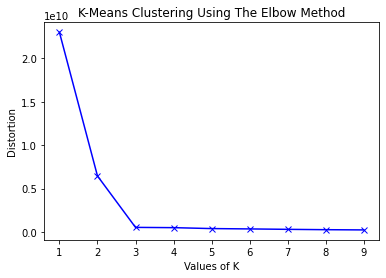

In [95]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('K-Means Clustering Using The Elbow Method')
plt.show()

In [96]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 8.921075576421535e+29
2 : 1.1355529192154474e+29
3 : 1.0049946595458316e+25
4 : 4.327813121349534e+22
5 : 2.2817655842843165e+22
6 : 1.7341199007523839e+22
7 : 1.3571204915627181e+22
8 : 1.0840654831020705e+22
9 : 9.370287436316195e+21


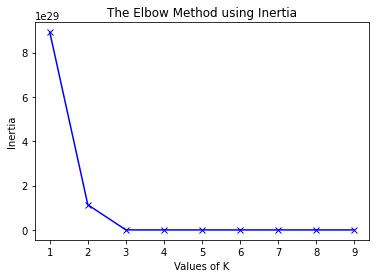

In [97]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [99]:

kmeans = KMeans(n_clusters=3, random_state=0).fit(app_traffic)
kmeans.labels_


array([0, 0, 0, ..., 0, 2, 1])

In [102]:
X, _ = make_blobs(n_samples=10, centers=3, n_features=3)

kmeans = KMeans(n_clusters=3)
y = kmeans.fit_predict(app_traffic[['Gaming','Other Apps','Youtube']])

app_traffic['Cluster'] = y

app_traffic.head()

,MSISDN/Number,Social media,Google,Email,Youtube,Netflix,Gaming,Other Apps,Cluster
0,3.360100e+10,2232135.0,4389005.0,1331362.0,21624548.0,27180981.0,8.124587e+08,386570872.0,1
1,3.360100e+10,2660565.0,5334863.0,3307781.0,12432223.0,11221763.0,1.197501e+08,281710071.0,1
2,3.360100e+10,3195623.0,3443126.0,3205380.0,21333570.0,19353900.0,5.388277e+08,501693672.0,1
3,3.360101e+10,280294.0,9678493.0,2284670.0,6977321.0,1942092.0,3.911261e+08,35279702.0,1
4,3.360101e+10,2912542.0,18499616.0,3305469.0,41533002.0,49201724.0,1.314798e+09,804804484.0,0


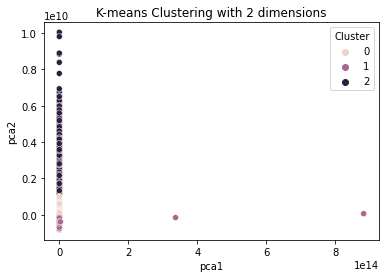

In [104]:
### Run PCA to reduce the dimensions in pca_num_components dimensions
pca_num_components = 2
reduced_data = PCA(n_components=pca_num_components).fit_transform(app_traffic)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=app_traffic['Cluster'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()

In [105]:
K=3
# Select random observation as centroids
Centroids = (X.sample(n=K))
plt.scatter(X['Gaming'],X['Other Apps'],c='black')
plt.scatter(Centroids['Gaming'],Centroids['Other'],Centroids['Youtube'],c='red')
plt.xlabel('Gaming Data Volumes')
plt.ylabel('Other Apps Data Volumes')

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'sample'

## 3. User Experience Analysis
We analyze user experience by looking at the TCP and RTT parameters
#### Aggregate users based on experience parameters (Average TCP Retransmission rates, Average RTT, Average Throughput)

In [108]:
user_experience= telco_clean.groupby(['MSISDN/Number', 'Handset Type']).aggregate({'TCP DL Retrans. Vol (Bytes)': 'sum', 
                                                            'TCP UL Retrans. Vol (Bytes)': 'sum',
                                                            'Avg RTT UL (ms)':'sum',
                                                            'Avg RTT DL (ms)' :'sum',
                                                            'Avg Bearer TP DL (kbps)':'sum',
                                                            'Avg Bearer TP UL (kbps)':'sum',
                                                             }).reset_index()
user_experience.head()

,MSISDN/Number,Handset Type,TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Avg RTT UL (ms),Avg RTT DL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
0,3.360100e+10,Huawei P20 Lite Huawei Nova 3E,1330.0,1330.0,0.0,46.0,37.0,39.0
1,3.360100e+10,Apple iPhone 7 (A1778),1330.0,1330.0,1.0,30.0,48.0,51.0
2,3.360100e+10,undefined,1330.0,1330.0,5.0,28.0,48.0,49.0
3,3.360101e+10,Apple iPhone 5S (A1457),1066.0,1330.0,15.0,69.0,204.0,44.0
4,3.360101e+10,Apple iPhone Se (A1723),9350960.0,22532.0,5.0,114.0,40395.0,16449.0


In [109]:
#creating a dict with columns to be combined
columns = {'Average TCP retransmission':['TCP DL Retrans. Vol (Bytes)','TCP UL Retrans. Vol (Bytes)'],
           'Average RTT':['Avg RTT UL (ms)', 'Avg RTT DL (ms)'],
           'Average throughput':['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']
          }
user_experience= combineColumns(user_experience, columns)
user_experience.head()

,MSISDN/Number,Handset Type,Average TCP retransmission,Average RTT,Average throughput
0,3.360100e+10,Huawei P20 Lite Huawei Nova 3E,2660.0,46.0,76.0
1,3.360100e+10,Apple iPhone 7 (A1778),2660.0,31.0,99.0
2,3.360100e+10,undefined,2660.0,33.0,97.0
3,3.360101e+10,Apple iPhone 5S (A1457),2396.0,84.0,248.0
4,3.360101e+10,Apple iPhone Se (A1723),9373492.0,119.0,56844.0


#### Perform descriptive statistics on user experience parameters

In [111]:
user_experience[['Average TCP retransmission', 'Average RTT', 'Average throughput']].describe()

,Average TCP retransmission,Average RTT,Average throughput
count,1.063580e+05,106358.000000,106358.000000
mean,1.237751e+07,148.878796,21008.074146
std,1.542268e+08,661.826364,42498.384338
min,9.700000e+01,0.000000,0.000000
25%,2.660000e+03,33.000000,97.000000
50%,5.320000e+03,60.000000,290.000000
75%,3.215252e+05,113.000000,26530.000000
max,8.354209e+09,96924.000000,902222.000000


##### Average TCP Retransmission Values Analysis
Top 10 average retransmission values

In [114]:
user_experience[['MSISDN/Number', 'Handset Type', 'Average TCP retransmission']].sort_values(by='Average TCP retransmission', ascending=False).head(10)

,MSISDN/Number,Handset Type,Average TCP retransmission
66556,3.366773e+10,Huawei B528S-23A,8.354209e+09
33952,3.365908e+10,Huawei B528S-23A,7.941860e+09
42168,3.366098e+10,Huawei B528S-23A,7.374140e+09
94240,3.376128e+10,Huawei B528S-23A,6.043978e+09
97761,3.376264e+10,Huawei B528S-23A,5.879989e+09
25634,3.365066e+10,Huawei B528S-23A,5.593366e+09
51402,3.366318e+10,Huawei B528S-23A,5.566929e+09
99472,3.376357e+10,Huawei B528S-23A,5.179459e+09
70591,3.366905e+10,Huawei B528S-23A,5.174218e+09
31799,3.365864e+10,Huawei B528S-23A,5.165857e+09


Bottom 10 Average retransmission values

In [115]:
user_experience[['MSISDN/Number', 'Handset Type', 'Average TCP retransmission']].sort_values(by='Average TCP retransmission').head(10)

,MSISDN/Number,Handset Type,Average TCP retransmission
23344,3.365013e+10,Apple iPhone 5S (A1457),97.0
6317,3.361478e+10,Huawei Ascend Mate7,128.0
96527,3.376206e+10,Apple iPhone 8 (A1905),129.0
13472,3.362636e+10,Apple iPhone 7 (A1778),134.0
2160,3.360783e+10,Apple iPhone 5C (A1529),143.0
25723,3.365068e+10,Xiaomi Communica. Mi Max3,176.0
101734,3.376964e+10,Apple iPhone 5S (A1457),176.0
105288,3.378420e+10,Apple iPhone Xr (A2108),177.0
77732,3.367937e+10,Samsung Galaxy S6 Plus (Sm-G928),179.0
88981,3.369969e+10,Samsung Galaxy Trend Lite 2 (Sm-G318X),182.0


Most common average retransmission

In [117]:
user_experience['Average TCP retransmission'].mode()

0    2660.0
dtype: float64

##### Average RTT Values Analysis

Top 10 Average RTT Values

In [119]:
user_experience[['MSISDN/Number', 'Handset Type', 'Average RTT']].sort_values(by='Average RTT', ascending = False).head(10)

,MSISDN/Number,Handset Type,Average RTT
47760,3.366232e+10,Apple iPhone 8 (A1905),96924.0
41748,3.366087e+10,Apple iPhone 6 (A1586),64670.0
79870,3.368369e+10,Lg Lg-D315,54848.0
85281,3.369855e+10,Huawei B528S-23A,46021.0
95968,3.376181e+10,Huawei B528S-23A,37084.0
69823,3.366879e+10,Huawei B528S-23A,36304.0
93409,3.376094e+10,Samsung Galaxy S7 Edge (Sm-G935X),27278.0
1699,3.360679e+10,Samsung Galaxy S9 Plus (Sm-G965F),26300.0
73900,3.367182e+10,Samsung Galaxy S6 Edge (Sm-G925X),25715.0
103848,3.378187e+10,Apple iPhone 6S (A1688),25388.0


Bottom 10 Average RTT Values

In [120]:
user_experience[['MSISDN/Number', 'Handset Type', 'Average RTT']].sort_values(by='Average RTT').head(10)

,MSISDN/Number,Handset Type,Average RTT
28729,3.365298e+10,Huawei P20 Pro,0.0
44537,3.366158e+10,Huawei Pct-L29,0.0
38879,3.366020e+10,Apple iPhone X (A1901),2.0
83000,3.369505e+10,Huawei P20,4.0
35859,3.365949e+10,Apple iPhone 6S (A1688),5.0
69345,3.366862e+10,Apple iPhone 6S (A1688),6.0
21859,3.364768e+10,Huawei Honor View10,8.0
74094,3.367220e+10,Huawei P20 Lite Huawei Nova 3E,9.0
3858,3.361085e+10,Samsung Galaxy S6 Edge (Sm-G925X),9.0
17769,3.363468e+10,Huawei P20 Lite Huawei Nova 3E,10.0


Most common Average RTT Value

In [121]:
user_experience['Average RTT'].mode()

0    33.0
dtype: float64

##### Average Throughput Values Analysis

Top 10 Average Throughput Values

In [122]:
user_experience[['MSISDN/Number', 'Handset Type', 'Average throughput']].sort_values(by='Average throughput', ascending =False).head(10)

,MSISDN/Number,Handset Type,Average throughput
97134,3.376233e+10,Samsung Galaxy A8 (2018),902222.0
69592,3.366871e+10,Huawei B528S-23A,840424.0
36077,3.365955e+10,Huawei B528S-23A,798342.0
72814,3.366995e+10,Huawei B528S-23A,690815.0
68707,3.366843e+10,Huawei B528S-23A,676858.0
84087,3.369817e+10,undefined,618797.0
13069,3.362570e+10,Samsung Galaxy S9 Sm-G960F Ds,564179.0
29162,3.365808e+10,Huawei B528S-23A,550352.0
97761,3.376264e+10,Huawei B528S-23A,549661.0
60491,3.366566e+10,Huawei B528S-23A,530353.0


Bottom 10 Average Throughput Values

In [123]:
user_experience[['MSISDN/Number', 'Handset Type', 'Average throughput']].sort_values(by='Average throughput').head(10)

,MSISDN/Number,Handset Type,Average throughput
92629,3.376059e+10,undefined,0.0
85423,3.369859e+10,undefined,0.0
17190,3.363359e+10,Apple iPhone 7 (A1778),0.0
41159,3.366074e+10,Huawei B528S-23A,0.0
41750,3.366087e+10,Samsung Galaxy S8 (Sm-G950F),0.0
41935,3.366092e+10,undefined,0.0
56610,3.366462e+10,Apple iPhone 6 (A1586),0.0
10587,3.362166e+10,undefined,0.0
17353,3.363392e+10,Samsung Galaxy A5 (Sm-A510X),0.0
102767,3.377776e+10,Huawei P20 Lite Huawei Nova 3E,0.0


Most common Average Throughput value

In [124]:
user_experience['Average throughput'].mode()

0    15.0
dtype: float64

#### Removing Outliers from the dataset

In [125]:
# function to calculate interquartile range
def find_iqr(x):
    IQR= np.subtract(*np.percentile(x, [75, 25]))
    return IQR

#calculate IQR for 'Average TCP retransmission', 'Average RTT', 'Average throughput' columns
user_experience[['Average TCP retransmission', 'Average RTT', 'Average throughput']].apply(find_iqr)

Average TCP retransmission    318865.25
Average RTT                       80.00
Average throughput             26433.00
dtype: float64

In [129]:
# Function to remove outliers
def remove_outliers(df,y):
    x=df[y]
    Q1= np.percentile(x, 25, interpolation = 'midpoint')
    Q3= np.percentile(x, 75, interpolation = 'midpoint')
    IQR= np.subtract(*np.percentile(x, [75, 25]))
    upper = Q3 +1.5*IQR
    lower = Q1 - 1.5*IQR
    median = x.median
    
    #Replacing Higher_outlier outliers with median
    nan=np.where(df[y]>Q3)
    x.fillna(x.median(), inplace=True)
    
    #Replacing lower outliers with median
    nan=np.where(df[y]>Q1)
    x.fillna(x.median(), inplace=True)   
    
    return df 

In [135]:
#Remove outliers in Average TCP retransmissions
user_experience=remove_outliers(user_experience,'Average TCP retransmission')
user_experience.head()

,MSISDN/Number,Handset Type,Average TCP retransmission,Average RTT,Average throughput
0,3.360100e+10,Huawei P20 Lite Huawei Nova 3E,2660.0,46.0,76.0
1,3.360100e+10,Apple iPhone 7 (A1778),2660.0,31.0,99.0
2,3.360100e+10,undefined,2660.0,33.0,97.0
3,3.360101e+10,Apple iPhone 5S (A1457),2396.0,84.0,248.0
4,3.360101e+10,Apple iPhone Se (A1723),9373492.0,119.0,56844.0


In [137]:
#Remove outliers in Average RTT 
user_experience=remove_outliers(user_experience,'Average RTT')
user_experience.head()

,MSISDN/Number,Handset Type,Average TCP retransmission,Average RTT,Average throughput
0,3.360100e+10,Huawei P20 Lite Huawei Nova 3E,2660.0,46.0,76.0
1,3.360100e+10,Apple iPhone 7 (A1778),2660.0,31.0,99.0
2,3.360100e+10,undefined,2660.0,33.0,97.0
3,3.360101e+10,Apple iPhone 5S (A1457),2396.0,84.0,248.0
4,3.360101e+10,Apple iPhone Se (A1723),9373492.0,119.0,56844.0


In [138]:
#Remove outliers in Average Throughput 
user_experience=remove_outliers(user_experience,'Average throughput')
user_experience.head()

,MSISDN/Number,Handset Type,Average TCP retransmission,Average RTT,Average throughput
0,3.360100e+10,Huawei P20 Lite Huawei Nova 3E,2660.0,46.0,76.0
1,3.360100e+10,Apple iPhone 7 (A1778),2660.0,31.0,99.0
2,3.360100e+10,undefined,2660.0,33.0,97.0
3,3.360101e+10,Apple iPhone 5S (A1457),2396.0,84.0,248.0
4,3.360101e+10,Apple iPhone Se (A1723),9373492.0,119.0,56844.0


#### Finding Q 3 for Average TCP retransmission, Average RTT, and  Average Througput

In [139]:
#finding Q3 in AVerage TCP retransmission
x =user_experience['Average TCP retransmission']
Q3_1= np.percentile(x, [75], interpolation = 'midpoint')
Q3_1

array([321479.5])

In [140]:
#finding Q3 in AVerage RTT Values
x =user_experience['Average RTT']
Q3_2= np.percentile(x, [75], interpolation = 'midpoint')
Q3_2

array([113.])

In [141]:
#finding Q3 in AVerage Throughput 
x =user_experience['Average throughput']
Q3_3= np.percentile(x, [75], interpolation = 'midpoint')
Q3_3

array([26530.])

#### Visualization

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Average TCP retransmission'>

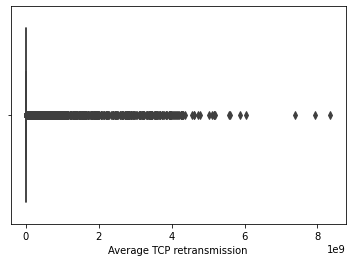

In [142]:
sns.boxplot(user_experience['Average TCP retransmission'])

In [143]:
#Replacing the outliers with mean
user_experience['Average TCP retransmission'].fillna(user_experience['Average TCP retransmission'].median(), inplace=True)

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Average RTT'>

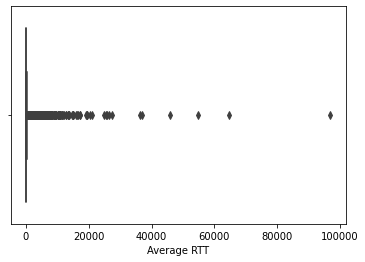

In [144]:
user_experience['Average RTT'].fillna(user_experience['Average RTT'].median(), inplace=True)
sns.boxplot(user_experience['Average RTT'])

C:\Users\User\anaconda3\envs\envMysql\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Average throughput'>

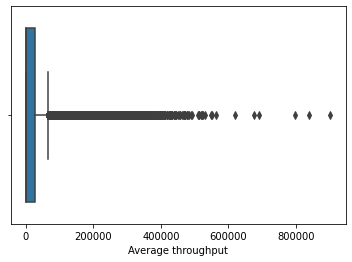

In [145]:
user_experience['Average throughput'].fillna(user_experience['Average throughput'].median(), inplace=True)
sns.boxplot(user_experience['Average throughput'])

### K-Means Clustering (k=3)

In [153]:
# k-means (k=3) to classify customers in three groups of engagement.
kmeans = KMeans(n_clusters=3, random_state=0).fit(user_experience[['Average TCP retransmission', 'Average RTT', 'Average throughput']])
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

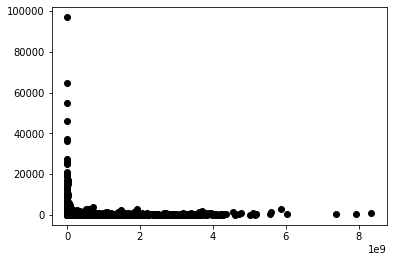

In [154]:
X = user_experience
#Visualise data points
#,X['Average throughput']
plt.scatter(X['Average TCP retransmission'],X['Average RTT'],c='black')

plt.show()

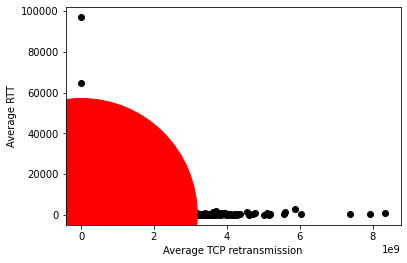

In [155]:
K=3

# Select random observation as centroids
Centroids = (X.sample(n=K))
plt.scatter(X['Average TCP retransmission'],X['Average RTT'],c='black')
plt.scatter(Centroids['Average TCP retransmission'],Centroids['Average RTT'],Centroids['Average throughput'],c='red')
plt.xlabel('Average TCP retransmission')
plt.ylabel('Average RTT')

plt.show()

In [157]:
x= user_experience.to_numpy()

In [158]:
engagement_score=[]
for i in x:
    engagement_score.append(euclidean_distances([i.tolist()],[Centroids[i].tolist()]))

KeyError: "None of [Index([33601001722.0, 'Huawei P20 Lite Huawei Nova 3E', 2660.0, 46.0, 76.0], dtype='object')] are in the [columns]"

In [159]:

#K-Means Clustering
# Step 3 - Assign all the points to the closest cluster centroid
# Step 4 - Recompute centroids of newly formed clusters
# Step 5 - Repeat step 3 and 4

diff = 1
j=0

while(diff!=0):
    XD=X
    i=1
    for index1,row_c in Centroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c['Average TCP retransmission']-row_d['Average TCP retransmission'])**2
            d2=(row_c['Average RTT']-row_d['Average RTT'])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        X[i]=ED
        i=i+1

    C=[]
    for index,row in X.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    X["Cluster"]=C
    Centroids_new = X.groupby(["Cluster"]).mean()[['Average RTT','Average TCP retransmission']]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (Centroids_new['Average RTT'] - Centroids['Average RTT']).sum() + (Centroids_new['Average RTT'] - Centroids['Average RTT']).sum()
        print(diff.sum())
    Centroids = X.groupby(["Cluster"]).mean()[['Average TCP retransmission','Average RTT']]

367.286659800783
155.17167294847016
104.26577416354783
57.107544655360186
45.06593387308021
-12.366406801089738
-20.42762968812798
-5.187183875393885
7.929113432552072
-0.5906984965016022
1.8537128480074898
-23.81424339443214
6.625677338962305
3.1873552887045093
-11.80271116979219
2.2660842646022274
-4.605405534198553
1.0693958327497057
0.0


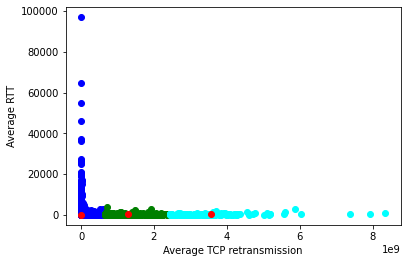

In [160]:
color=['blue','green','cyan']
for k in range(K):
    data=X[X["Cluster"]==k+1]
    plt.scatter(data['Average TCP retransmission'],data['Average RTT'],c=color[k])
plt.scatter(Centroids['Average TCP retransmission'],Centroids['Average RTT'],c='red')
plt.xlabel('Average TCP retransmission')
plt.ylabel('Average RTT')
plt.show()